In [1]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import torch as ch

from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import matplotlib.pyplot as plt
import seaborn as sns
import IPython 

from delphi.distributions.unknown_truncation_normal import TruncatedNormal
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata, cov
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader

In [7]:
args = Parameters({ 
    'samples': 1500, 
    'batch_size': 10, 
    'iter_': 1, 
    'lr': 1e-1, 
    'out_dir': '/Users/patroklos/Desktop/exp/hermite', 
    'exp': 'normalized_', 
    'table_name': 'logs', 
    'trials': 20,
    'var': 20
})

Synthetic Data Experiment for 1 Dimensional Censored Gaussian Distributions 

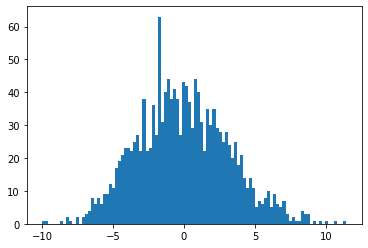

In [8]:
M = MultivariateNormal(ch.zeros(1), 10*ch.ones(1, 1))
samples = M.sample([args.samples])

plt.hist(samples.flatten(), bins=100)
plt.show()

Truncate the Dataset

alpha:  0.5233333333333333
empirical mean:  tensor([-2.5197])
empirical covariance matrix:  tensor([[3.2014]])


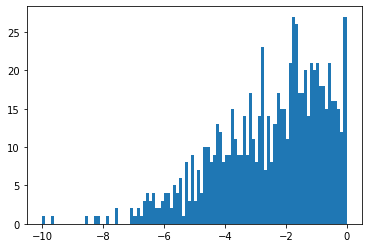

In [9]:
phi = oracle.Right(Tensor([0.0]))
indices = phi(samples).nonzero(as_tuple=False)[:,0]
S = samples[indices]
alpha = S.size(0) / samples.size(0)
print("alpha: ", alpha)
emp_mean = S.mean(0)
print("empirical mean: ", S.mean(0))
emp_covariance_matrix = cov(S)
print("empirical covariance matrix: ", cov(S))


plt.hist(S.flatten(), bins=100)
plt.show()

Run algorithm to Remove Bias from the Dataset

In [10]:
truncated = TruncatedNormal(alpha=alpha,
                           iter_=5,
                            bs=args.batch_size,
                           val=50)
truncated.fit(S)

Iteration 1 | Log Likelihood: 2.232
Iteration 2 | Log Likelihood: 1.561
Iteration 3 | Log Likelihood: 1.526
Iteration 4 | Log Likelihood: 1.656
Iteration 5 | Log Likelihood: 1.543


In [11]:
print("estimated mean: ", truncated.loc)
print("estimated variance: ", truncated.variance)

estimated mean:  tensor([-0.6692])
estimated variance:  tensor([[7.3972]])


In [12]:
store = Store(args.out_dir + '/' + args.exp)

schema = { 
    'kl_div_emp': float, 
    'kl_div_truncated': float,
    'var': int,
    'alpha': float,
}

# right truncate at 0
phi = oracle.Right(Tensor([0.0]))


store.add_table(args.table_name, schema)

for i in range(args.trials): 
    for var in range(1, args.var + 1):
        # create new dataset
        gt_loc, gt_scale = Tensor([0.0]), var * ch.ones(1, 1)
        gt_dist = MultivariateNormal(gt_loc, gt_scale)
        samples = gt_dist.sample([args.samples])

        # truncate
        indices = phi(samples).nonzero()[:,0]
        S = samples[indices]
        alpha = S.size(0) / samples.size(0)

        emp_dist = MultivariateNormal(S.mean(0), S.var(0) * ch.ones(1, 1))
        
        truncated = TruncatedNormal(alpha=alpha, 
                              iter_=args.iter_,
                              bs=args.batch_size,
                              lr=args.lr)
        truncated.fit(S)

        trunc_dist = MultivariateNormal(truncated.loc, truncated.variance)

        kl_trunc = float(kl_divergence(gt_dist, trunc_dist))
        kl_emp = float(kl_divergence(gt_dist, emp_dist))

        store[args.table_name].update_row({ 
            'kl_div_emp': kl_emp, 
            'kl_div_truncated': kl_trunc,
            'var': var,
            'alpha': alpha,
        })
        store[args.table_name].flush_row()
        
        IPython.display.clear_output()
    
store.close()

In [13]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(args.table_name)
reader.close()
logs.head(10)

100%|██████████| 1/1 [00:00<00:00, 76.55it/s]


,kl_div_emp,kl_div_truncated,var,alpha,exp_id
0,1.321778,0.061258,1,0.518000,505f60e0-8d31-4937-8744-32ca9c9ac0fd
1,1.288916,0.016914,2,0.509333,505f60e0-8d31-4937-8744-32ca9c9ac0fd
2,1.319059,0.004841,3,0.503333,505f60e0-8d31-4937-8744-32ca9c9ac0fd
3,1.237815,0.084883,4,0.484000,505f60e0-8d31-4937-8744-32ca9c9ac0fd
4,1.270113,0.051793,5,0.481333,505f60e0-8d31-4937-8744-32ca9c9ac0fd
5,1.175101,0.035412,6,0.506667,505f60e0-8d31-4937-8744-32ca9c9ac0fd
6,1.434405,0.012583,7,0.496667,505f60e0-8d31-4937-8744-32ca9c9ac0fd
7,1.161568,0.070578,8,0.508667,505f60e0-8d31-4937-8744-32ca9c9ac0fd
8,1.407035,0.012003,9,0.488667,505f60e0-8d31-4937-8744-32ca9c9ac0fd
9,1.239082,0.438519,10,0.497333,505f60e0-8d31-4937-8744-32ca9c9ac0fd


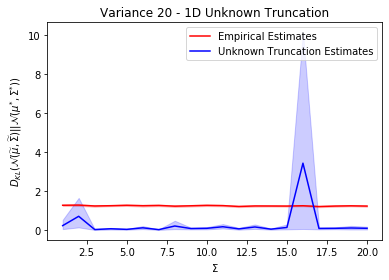

In [14]:
sns.lineplot(data=logs, x='var', y='kl_div_emp', color='red', label='Empirical Estimates')
ax = sns.lineplot(data=logs, x='var', y='kl_div_truncated', color='blue', label='Unknown Truncation Estimates')
ax.legend()
ax.set_xlabel('$\Sigma$')
ax.set_ylabel('$D_{KL}(\mathcal{N}(\widetilde{\mu}, \widetilde{\Sigma}) || \mathcal{N}(\mu^{*}, \Sigma^{*}))$')
ax.set_title('Variance 20 - 1D Unknown Truncation')
plt.show()

In [15]:
import numpy as np
np.unique(logs['var'].to_numpy())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [18]:
logs[logs['var'] == 16]

,kl_div_emp,kl_div_truncated,var,alpha,exp_id
15,1.108221,0.327126,16,0.507333,505f60e0-8d31-4937-8744-32ca9c9ac0fd
35,1.306798,0.064150,16,0.510667,505f60e0-8d31-4937-8744-32ca9c9ac0fd
55,1.318504,0.186619,16,0.501333,505f60e0-8d31-4937-8744-32ca9c9ac0fd
75,1.183969,0.011616,16,0.501333,505f60e0-8d31-4937-8744-32ca9c9ac0fd
95,1.125478,0.228651,16,0.492667,505f60e0-8d31-4937-8744-32ca9c9ac0fd
115,1.296839,0.071201,16,0.517333,505f60e0-8d31-4937-8744-32ca9c9ac0fd
135,1.354925,0.112055,16,0.506000,505f60e0-8d31-4937-8744-32ca9c9ac0fd
155,1.270953,0.052432,16,0.470000,505f60e0-8d31-4937-8744-32ca9c9ac0fd
175,1.199515,0.099653,16,0.500000,505f60e0-8d31-4937-8744-32ca9c9ac0fd
195,1.299870,0.124652,16,0.518667,505f60e0-8d31-4937-8744-32ca9c9ac0fd


In [52]:
(phi(samples)[..., None] * samples).nonzero()

tensor([[   1,    0],
        [   2,    0],
        [   3,    0],
        ...,
        [1496,    0],
        [1497,    0],
        [1499,    0]])

In [46]:
samples

tensor([[ 3.9754],
        [-5.4669],
        [-6.6760],
        ...,
        [-5.2984],
        [ 5.0027],
        [-1.2421]])

In [55]:
logs[logs['var'] == 7]

,kl_div_emp,kl_div_truncated,var,exp_id
6,1.164485,0.015808,7,494ffae7-58d2-46cb-ab95-d6ddf6df050e
26,1.225474,0.467732,7,494ffae7-58d2-46cb-ab95-d6ddf6df050e
46,1.210201,0.403131,7,494ffae7-58d2-46cb-ab95-d6ddf6df050e
66,1.185498,0.301931,7,494ffae7-58d2-46cb-ab95-d6ddf6df050e
86,1.287546,14.633307,7,494ffae7-58d2-46cb-ab95-d6ddf6df050e
106,1.202697,0.278773,7,494ffae7-58d2-46cb-ab95-d6ddf6df050e
126,1.160196,0.061865,7,494ffae7-58d2-46cb-ab95-d6ddf6df050e
146,1.167917,0.010333,7,494ffae7-58d2-46cb-ab95-d6ddf6df050e
166,1.205645,0.021090,7,494ffae7-58d2-46cb-ab95-d6ddf6df050e
186,1.234809,0.030985,7,494ffae7-58d2-46cb-ab95-d6ddf6df050e


In [17]:
from scipy.linalg import sqrtm

In [19]:
sqrtm(2*ch.ones(1, 1).numpy())

array([[1.4142135]], dtype=float32)